In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import torch
from torch.utils.tensorboard import SummaryWriter
import time
%load_ext tensorboard

#from "Tools.py" import 
seed=42
class ANN:
    def __init__(self,model,seed=0,n_epoch=10,batch_size=64,lr=0.001, device = "cpu",dtype = torch.float):
        self.seed = seed
        self.model = model
        self.batch_size = batch_size
        self.lr = lr
        self.scale_x = StandardScaler()
        self.scale_y = StandardScaler()
        self.device = device
        self.n_epoch = n_epoch
        self.losses = []
        self.losses_test = None
        self.optim = torch.optim.Adam(model.parameters(),lr=self.lr)
        self.loss_fn = torch.nn.MSELoss(reduction="mean")
        self.model = self.model.to(dtype)
        self.model = self.model.to(device)
        self.dtype = dtype

    def fit(self, x, y,test=False,x_test=None,y_test=None,name = "fit"):
        x_ = x.copy()
        y_ = y.copy()
        x_ = self.scale_x.fit_transform(np.array(x_))
        y_ = self.scale_y.fit_transform(np.array(y_).reshape(-1, 1)).reshape(len(y_))
        x_ = torch.as_tensor(x_,dtype=self.dtype)
        y_ = torch.as_tensor(y_,dtype=self.dtype)
        torch.manual_seed = self.seed
        writer = SummaryWriter("runs/" + name)
        writer.add_graph(self.model,x_.to(self.device))
        if test:
            self.losses_test = []
            x_t = x_test.copy()
            y_t = y_test.copy()
            x_t = self.scale_x.transform(np.array(x_t))
            y_t = self.scale_y.transform(np.array(y_t).reshape(-1, 1)).reshape(len(y_t))
            x_t = torch.as_tensor(x_t,dtype=self.dtype)
            y_t = torch.as_tensor(y_t,dtype=self.dtype)
        for epoch in range(self.n_epoch):
            self._train(x_,y_)
            #print(epoch)
            writer.add_scalars(main_tag = "loss",tag_scalar_dict={"train":self.losses[-1]},global_step=epoch)
            if test:
                self._test(x_t,y_t)
                writer.add_scalars(main_tag = "loss",tag_scalar_dict={"test":self.losses_test[-1]},global_step=epoch)
            if epoch%100==99:
                if test:
                    self.save(epoch,name,x_,y_,x_t,y_t,test)
                else:
                    self.save(epoch,name,x_,y_,None,None,test)
                print(epoch+1)
                
        return self
    
    def _train(self,x,y):
        self.model.train()
        train = torch.utils.data.TensorDataset(x,y)
        train_loader = torch.utils.data.DataLoader(dataset=train,batch_size=self.batch_size,shuffle=True)
        mini =[]
        for x_batch,y_batch in train_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            yhat = self.model(x_batch)
            loss = self.loss_fn(yhat.view(len(yhat)),y_batch)
            mini.append(loss.item())
            loss.backward()
            self.optim.step()
            self.optim.zero_grad()
        self.losses.append(np.mean(mini))
        return
    
    def _test(self,x,y):
        self.model.eval()
        test = torch.utils.data.TensorDataset(x,y)
        test_loader = torch.utils.data.DataLoader(dataset=test,batch_size=self.batch_size,shuffle=False)
        mini =[]
        for x_batch,y_batch in test_loader:
            with torch.no_grad():
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                yhat = self.model(x_batch)
                loss = self.loss_fn(yhat.view(len(yhat)),y_batch)
                mini.append(loss.item())
        self.losses_test.append(np.mean(mini))
        return
    
    def save(self,epoch,name,x_,y_,x_t,y_t,test):
        data = {"epoch":epoch,"model":self.model.state_dict(),"opt":self.optim.state_dict(),"losses":self.losses,"losses_test":self.losses_test,"name":name,
               "x_":x_,"y_":y_,"x_t":x_t,"y_t":y_t,"test":test}
        torch.save(data,"temp_seed_"+str(self.seed)+"_n_epo_"+str(self.n_epoch)+"_batch_size_"+str(self.batch_size) + "_lr_"+str(self.lr)+ ".dat")
        
    def load(self,file):
        data = torch.load(file)
        x_ = data["x_"]
        y_ = data["y_"]
        self.losses = data["losses"]
        self.losses_test = data["losses_test"]
        writer = SummaryWriter("runs/" + data["name"])
        self.optim.load_state_dict(data["opt"])
        self.model.load_state_dict(data["model"])
        if data["test"]:
            x_t = data["x_t"]
            y_t = data["y_t"]
        for epoch in range(data["epoch"],self.n_epoch):
            self._train(x_,y_)
            #print(epoch)
            writer.add_scalars(main_tag = "loss",tag_scalar_dict={"train":self.losses[-1]},global_step=epoch)
            if data["test"]:
                self._test(x_t,y_t)
                writer.add_scalars(main_tag = "loss",tag_scalar_dict={"test":self.losses_test[-1]},global_step=epoch)
            if epoch%100==99:
                if data["test"]:
                    self.save(epoch,data["name"],x_,y_,x_t,y_t,data["test"])
                else:
                    self.save(epoch,data["name"],x_,y_,None,None,data["test"])
                print(epoch+1)       
        
    def predict(self, x): 
        x_ = self.scale_x.transform(x)
        x_ = torch.as_tensor(x_,dtype=self.dtype)
        self.model.eval()
        y_ = self.model(x_)
        return self.scale_y.inverse_transform(y_.detach().numpy())
    

### load dataset

In [2]:
banco = pd.read_csv("Life_Expectancy_Data.csv")
x = banco[["infant deaths","Year"," BMI ","Adult Mortality"]]
#x = banco["infant deaths"]
y =banco["Life expectancy "]
for col in x.columns:
    fil = x[col].isna()
    x = x[~fil]
    y = y[~fil]
x = x[~y.isna()]
y = y[~y.isna()]

In [3]:
banco.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

### create folders

In [3]:
cv = KFold(n_splits=10,shuffle =True,random_state=seed)
cross = cv.split(x)
x_train = []
x_test = []
y_train = []
y_test = []
for train_i,test_i in cross:
    x_train.append(x.iloc[train_i,:])
    x_test.append(x.iloc[test_i,:])
    y_train.append(y.iloc[train_i])
    y_test.append(y.iloc[test_i])

### define model

In [4]:
x = x_train[0]
y = y_train[0]
t = []
for i in [26,28,30,32,34,36,38,40]:
    model = torch.nn.Linear(4,1)
    ann = ANN(model,device="cpu",dtype=torch.float,n_epoch=30,lr=0.001,batch_size=i)
    start = time.time()
    a = ann.fit(x,y,True,x_test[0],y_test[0],name="bat_"+str(i))
    t.append(time.time() - start)

C:\Users\valenter\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [30]:
2606%36

14

In [5]:
ann.losses

[2.0734558954383386,
 1.7805285571199474,
 1.5387036050810958,
 1.2773956475835857,
 1.126390969211405,
 0.9678634098081877,
 0.8535435597101847,
 0.7686669221430114,
 0.689886362715201,
 0.6336980109865015,
 0.5971443905974879,
 0.5570652584234873,
 0.5432609771237229,
 0.509747767087185,
 0.4907300208102573,
 0.47667552756540704,
 0.4567316497365634,
 0.448212078574932,
 0.438256753439253,
 0.4296539170723973,
 0.4244141483848745,
 0.4225869436155666,
 0.4146988757631995,
 0.4078576537695798,
 0.4026848606087945,
 0.40268988049391546,
 0.40678677278937714,
 0.39787927540865814,
 0.39826752538933896,
 0.3955548536596876]

In [24]:
import pandas as pd
banco_res = pd.DataFrame({"real":y_train[0],"predict":ann.predict(x_train[0]).reshape([2606])})
banco_res

C:\Users\valenter\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



,real,predict
0,65.0,63.413498
1,59.9,62.825901
2,59.9,62.666248
3,59.5,62.227665
4,59.2,61.851513
...,...,...
2930,46.6,71.368256
2931,45.4,73.479790
2932,44.6,45.611534
2935,44.8,69.946945


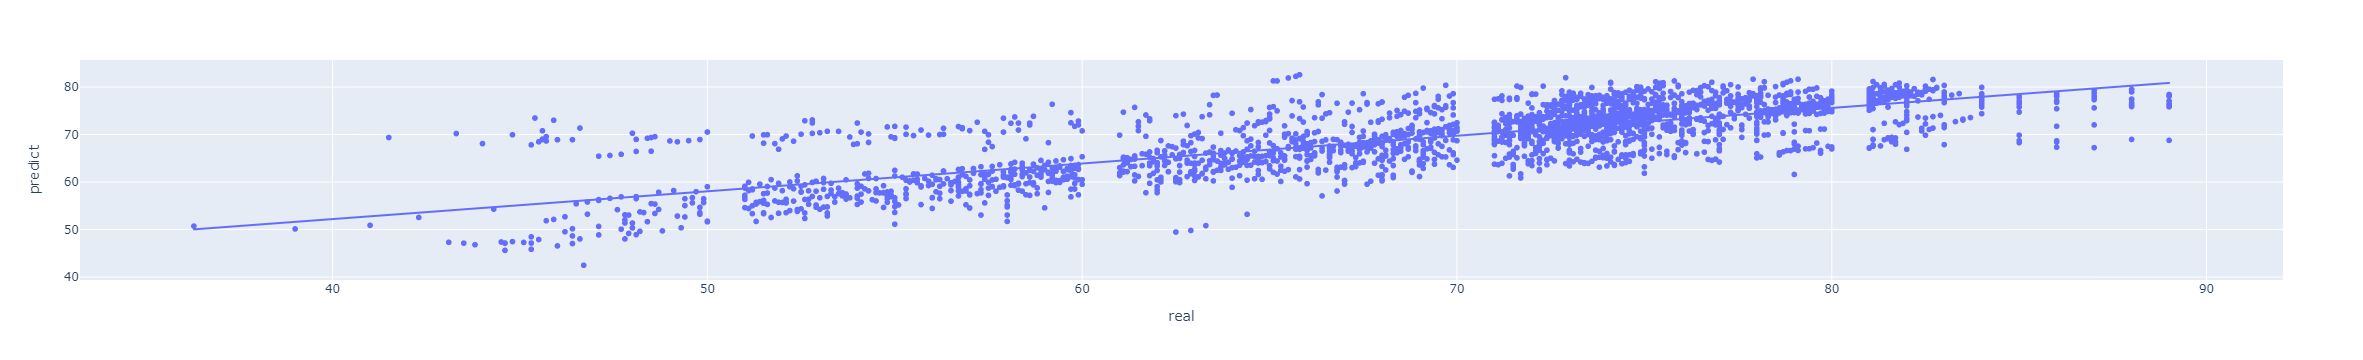

In [25]:
import plotly.express as px
px.scatter(banco_res,x="real",y="predict",trendline="ols")

In [9]:
y_test[3].shape

(290,)

In [98]:
a.loss_fn(a.model(a.x).view(len(a.x)),a.y).item()

0.3163611590862274

NameError: name 'tempfile' is not defined

In [8]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 14204), started 0:32:46 ago. (Use '!kill 14204' to kill it.)